In [40]:
# to suppress TF warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#

import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

### Generate, split and plot data

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


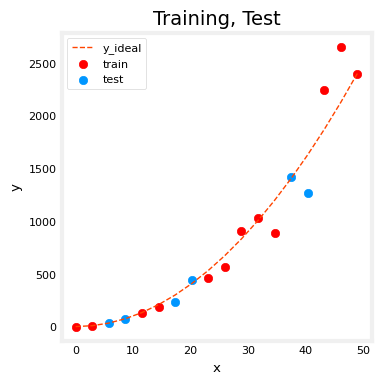

In [50]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

# Plot training and test datasets
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

### use sklearn (polynomial regression model) | compare training and test data errors

training err 58.01, test err 171215.01


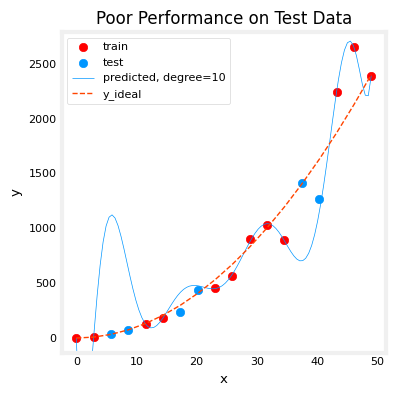

In [53]:
# create a model in sklearn, train on training data
degree = 10
#lmodel = lin_model(degree)
linear_model = LinearRegression()
poly = PolynomialFeatures(degree, include_bias=False)
scaler = StandardScaler()

#lmodel.fit(X_train, y_train)
X_train_mapped = poly.fit_transform(X_train.reshape(-1,1))
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
linear_model.fit(X_train_mapped_scaled, y_train)

# predict on training data, find training error
#yhat = lmodel.predict(X_train)
#err_train = lmodel.mse(y_train, yhat)
X_mapped = poly.transform(X_train.reshape(-1,1))
X_mapped_scaled = scaler.transform(X_mapped)
yhat = linear_model.predict(X_mapped_scaled)
err_train = mean_squared_error(y_train,yhat)/2   #sklearn doesn't have div by 2 in mse implementation

# predict on test data, find error
#yhat = lmodel.predict(X_test)
#err_test = lmodel.mse(y_test, yhat)

X_mapped = poly.transform(X_test.reshape(-1,1))
X_mapped_scaled = scaler.transform(X_mapped)
yhat = linear_model.predict(X_mapped_scaled)
err_test = mean_squared_error(y_test,yhat)/2   #sklearn doesn't have div by 2 in mse implementation

print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot

#y_pred = lmodel.predict(x).reshape(-1,1)
X_mapped = poly.transform(x.reshape(-1,1))
X_mapped_scaled = scaler.transform(X_mapped)
y_pred = linear_model.predict(X_mapped_scaled).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The computed error on the training set is substantially less than that of the test set.
The model is over fitting the data (has high variance) and it doesn't generalize well to other data.

### Try to use 3 datasets now (training, CV, test)
Split 60%, 20%, 20%

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


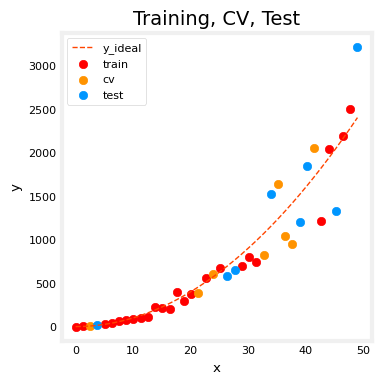

In [54]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

# Plot data
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

### Finding the optimal degree
Train the model repeatedly, increasing the degree of the polynomial each iteration

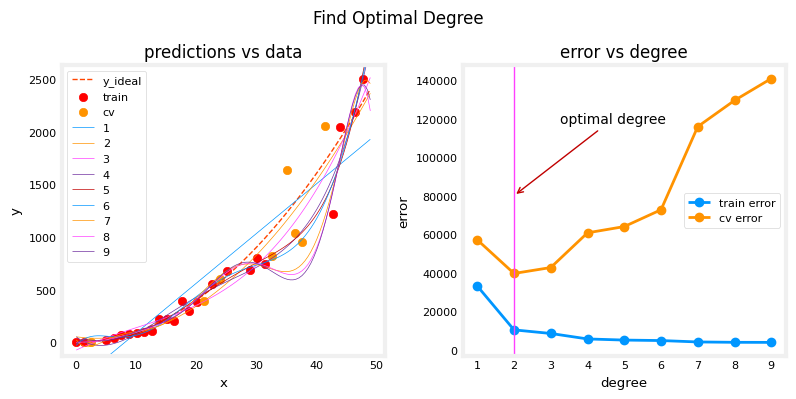

In [57]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

# Plot results
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

### Tuning Regularization (lambda)

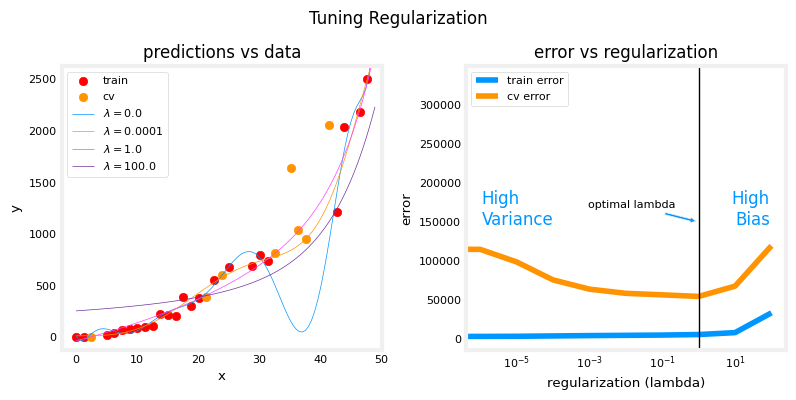

In [58]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv)

# Plot results
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

### Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

Note: adding more examples when the model has high bias (underfitting) does not improve performance

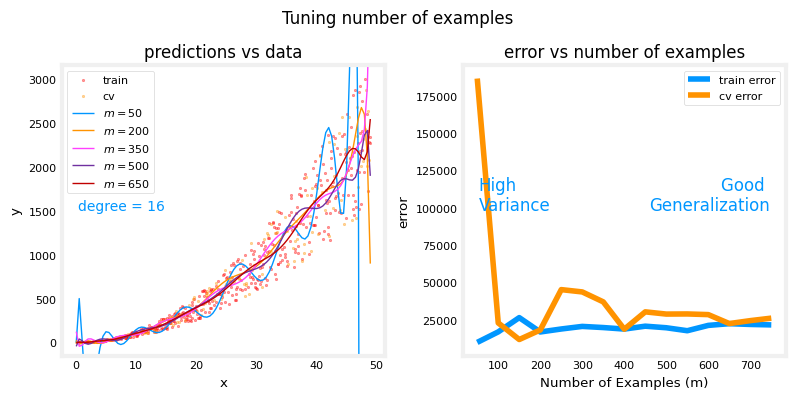

In [59]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

<a name="4"></a>
## NN evaluation / multi-class classification

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [17]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


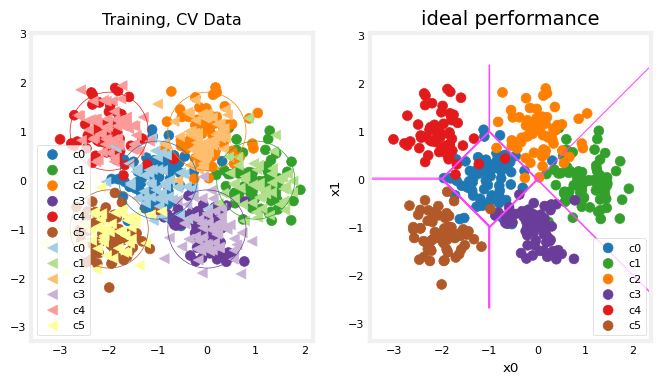

In [18]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [19]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    cerr = 0
    #for i in range(m):
    ### START CODE HERE ###
    out = yhat - y
    out = np.where(out==0, 0, 1)
    cerr = np.mean(out, axis=0)
        
    ### END CODE HERE ### 
    
    return(float(cerr))

In [20]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [22]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation = "relu"),
        Dense(units=40, activation="relu"),
        Dense(units=6, activation="linear")
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### END CODE HERE ### 
)

In [23]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.1195
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4274
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2867
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2818
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3004
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2481
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2244
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2285
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2154
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2074
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1681
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1625
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2035
Epoch 104/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1689
Epoch 105/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1578
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1491
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1638
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1500
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1481
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1526
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1547
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 303/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0699
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0599
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0726
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0735
Epoch 308/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0699
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0495
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0556
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0530
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0473
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0482
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0497
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0445
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 690/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0775
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0498
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0439
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0432
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0471
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0438
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0375
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0421
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0355
Epoch 891/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0333
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0333
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0298
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 897/1000
13/1

In [24]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 120)               360       
                                                                 
 dense_4 (Dense)             (None, 40)                4840      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 2s 2ms/step


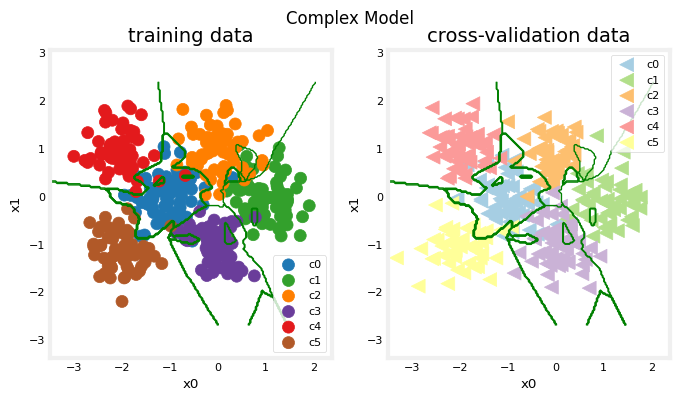

In [25]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [26]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 2ms/step
categorization error, training, complex model: 0.022
categorization error, cv,       complex model: 0.119


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [27]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=6, activation = "relu"),
        Dense(units=6, activation="linear")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [28]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 2.0500
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.5206
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.2727
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0747
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9137
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7759
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6712
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5888
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5255
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4756
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4374
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4091
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1972
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1996
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1949
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1929
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1935
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1922
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1927
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1942
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1934
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1926
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1938
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1886
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1858
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1836
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1857
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1844
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1885
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1823
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1894
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1832
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1838
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1831
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1836
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1744
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1735
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1765
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1720
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1731
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1730
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1730
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1748
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1747
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1738
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1703
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1707
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1717
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1729
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1703
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1706
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1705
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1714
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1706
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1704
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1733
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1687
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1686
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1722
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1683
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1695
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1708
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1689
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1694
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1681
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1701
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1687
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1700
Epoch 897/1000
13/1

In [29]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 18        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 2s 2ms/step


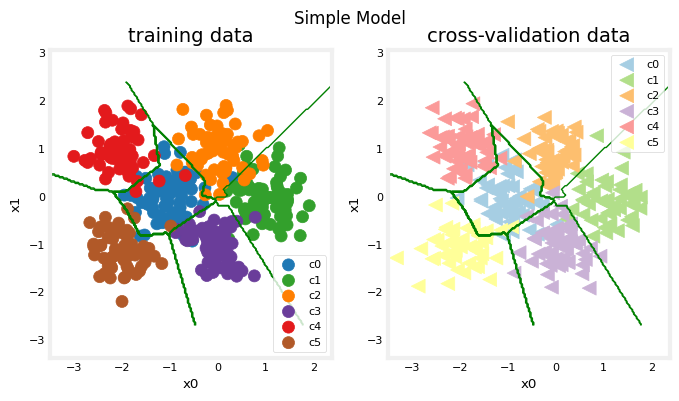

In [30]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [31]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 2ms/step
categorization error, training, simple model, 0.060, complex model: 0.022
categorization error, cv,       simple model, 0.084, complex model: 0.119


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [32]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation="linear")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [33]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 4.3266
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.6191
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.2715
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.0443
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9903
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9616
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9189
Epoch 8/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8637
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8160
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7747
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7547
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7571
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.4995
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4852
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4815
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4663
Epoch 105/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5154
Epoch 106/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4743
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4641
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4675
Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4632
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4594
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4608
Epoch 112/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4528
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3819
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3874
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3831
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4185
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3845
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3896
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3845
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3677
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3723
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3823
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3866
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3822
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3442
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3459
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3453
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3675
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3953
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3375
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3551
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3491
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3537
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3765
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3617
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4003
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3676
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3438
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3483
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3432
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3490
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3456
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3475
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3327
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3518
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3424
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4035
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3419
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3323
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3391
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3374
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3735
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3320
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3409
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3424
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3554
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3958
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3581
Epoch 897/1000
13/1

In [34]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               360       
                                                                 
 dense_9 (Dense)             (None, 40)                4840      
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 2s 2ms/step


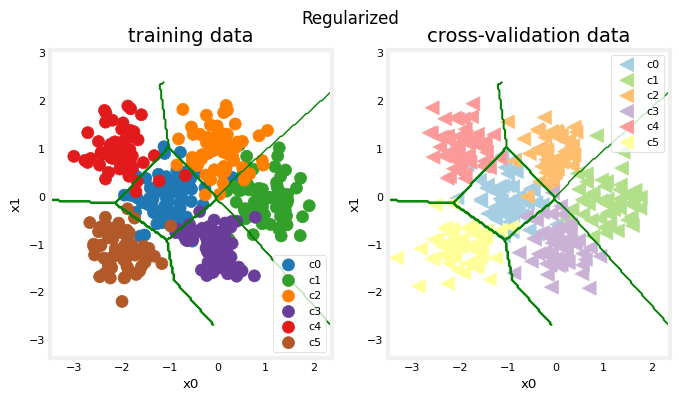

In [35]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [36]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 3ms/step
categorization error, training, regularized: 0.072, simple model, 0.060, complex model: 0.022
categorization error, cv,       regularized: 0.062, simple model, 0.084, complex model: 0.119


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [37]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9297
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4168
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3313
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3000
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2729
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2872
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2447
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2295
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2367
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2061
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2231
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2096
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1654
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1468
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1718
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1526
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1407
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1460
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1392
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1428
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1453
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1511
Epoch 113/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0809
Epoch 298/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0849
Epoch 300/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0985
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 302/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0974
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0955
Epoch 304/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0689
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0716
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 309/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0301
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0362
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0385
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0344
Epoch 498/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0332
Epoch 499/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0341
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 501/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0320
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0431
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0946
Epoch 504/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0805
Epoch 505/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0333
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 691/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0277
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0336
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0439
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 701/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.0675
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0936
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1199
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1614
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1442
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1436
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0789
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0437
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2446
Epoch 83/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2327
Epoch 84/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2356
Epoch 85/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2567
Epoch 86/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2315
Epoch 87/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2273
Epoch 88/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 89/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2339
Epoch 90/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2260
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2183
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2162
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2220
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.2180
Epoch 182/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2113
Epoch 183/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2098
Epoch 184/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2027
Epoch 185/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2064
Epoch 186/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1970
Epoch 187/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2049
Epoch 188/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2038
Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1968
Epoch 190/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2048
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2133
Epoch 192/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2087
Epoch 193/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.1724
Epoch 378/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1830
Epoch 379/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1879
Epoch 380/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1834
Epoch 381/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1823
Epoch 382/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1914
Epoch 383/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2004
Epoch 384/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1967
Epoch 385/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1822
Epoch 386/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1814
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1834
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1816
Epoch 389/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1818
Epoch 574/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1708
Epoch 575/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1638
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1602
Epoch 577/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1698
Epoch 578/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1775
Epoch 579/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1630
Epoch 580/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1697
Epoch 581/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1693
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1639
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1743
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1871
Epoch 585/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1524
Epoch 770/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1520
Epoch 771/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1565
Epoch 772/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1536
Epoch 773/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1591
Epoch 774/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1662
Epoch 775/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 776/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1506
Epoch 777/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1568
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1570
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1534
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1564
Epoch 781/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1602
Epoch 966/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1600
Epoch 967/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1584
Epoch 968/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1688
Epoch 969/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1585
Epoch 970/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1712
Epoch 971/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1657
Epoch 972/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1562
Epoch 973/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1494
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1589
Epoch 975/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1613
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1558
Epoch 977/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2821
Epoch 164/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2951
Epoch 165/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2949
Epoch 166/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2893
Epoch 167/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2855
Epoch 168/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2860
Epoch 169/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2894
Epoch 170/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2885
Epoch 171/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2748
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2625
Epoch 173/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2858
Epoch 174/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2927
Epoch 175/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2512
Epoch 360/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2711
Epoch 361/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2650
Epoch 362/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2908
Epoch 363/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2880
Epoch 364/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2729
Epoch 365/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2586
Epoch 366/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2599
Epoch 367/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2846
Epoch 368/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2786
Epoch 369/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2639
Epoch 370/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2569
Epoch 371/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2466
Epoch 556/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2334
Epoch 557/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2376
Epoch 558/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2507
Epoch 559/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2663
Epoch 560/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2531
Epoch 561/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2447
Epoch 562/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2599
Epoch 563/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2365
Epoch 564/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2460
Epoch 565/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2405
Epoch 566/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2452
Epoch 567/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2384
Epoch 752/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2543
Epoch 753/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2251
Epoch 754/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2379
Epoch 755/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2306
Epoch 756/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2485
Epoch 757/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2491
Epoch 758/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2400
Epoch 759/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2317
Epoch 760/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2397
Epoch 761/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2532
Epoch 762/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2390
Epoch 763/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2455
Epoch 948/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2502
Epoch 949/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 950/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2249
Epoch 951/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2323
Epoch 952/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2575
Epoch 953/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2482
Epoch 954/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2467
Epoch 955/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2334
Epoch 956/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2378
Epoch 957/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2368
Epoch 958/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2452
Epoch 959/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3616
Epoch 146/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3599
Epoch 147/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3884
Epoch 148/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3711
Epoch 149/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3609
Epoch 150/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3618
Epoch 151/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3627
Epoch 152/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3554
Epoch 153/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3759
Epoch 154/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3619
Epoch 155/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3637
Epoch 156/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3671
Epoch 157/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3297
Epoch 342/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3384
Epoch 343/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 344/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3203
Epoch 345/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3208
Epoch 346/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3327
Epoch 347/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3319
Epoch 348/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3384
Epoch 349/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3119
Epoch 350/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3323
Epoch 351/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3184
Epoch 352/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3396
Epoch 353/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3617
Epoch 538/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3228
Epoch 539/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2987
Epoch 540/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3139
Epoch 541/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3299
Epoch 542/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3368
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3286
Epoch 544/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3150
Epoch 545/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3071
Epoch 546/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3169
Epoch 547/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3343
Epoch 548/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3095
Epoch 549/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.2916
Epoch 734/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3141
Epoch 735/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3088
Epoch 736/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3123
Epoch 737/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3299
Epoch 738/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2907
Epoch 739/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3021
Epoch 740/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3047
Epoch 741/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3142
Epoch 742/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 743/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2974
Epoch 744/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2908
Epoch 745/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.2938
Epoch 930/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3125
Epoch 931/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3111
Epoch 932/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 933/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3009
Epoch 934/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3257
Epoch 935/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2924
Epoch 936/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2889
Epoch 937/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2887
Epoch 938/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3100
Epoch 939/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3003
Epoch 940/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2963
Epoch 941/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.6141
Epoch 29/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.6024
Epoch 30/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6268
Epoch 31/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6117
Epoch 32/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6218
Epoch 33/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6157
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6508
Epoch 35/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6545
Epoch 36/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6252
Epoch 37/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5899
Epoch 38/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5672
Epoch 39/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5663
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.4309
Epoch 226/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4178
Epoch 227/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4343
Epoch 228/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3883
Epoch 229/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4003
Epoch 230/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4071
Epoch 231/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3982
Epoch 232/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4084
Epoch 233/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3871
Epoch 234/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3856
Epoch 235/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3866
Epoch 236/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3943
Epoch 237/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3771
Epoch 422/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3900
Epoch 423/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3677
Epoch 424/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3687
Epoch 425/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3576
Epoch 426/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3579
Epoch 427/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3583
Epoch 428/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3659
Epoch 429/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3630
Epoch 430/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3607
Epoch 431/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3473
Epoch 432/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3549
Epoch 433/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3206
Epoch 618/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3625
Epoch 619/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4070
Epoch 620/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3938
Epoch 621/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3404
Epoch 622/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3367
Epoch 623/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3337
Epoch 624/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3240
Epoch 625/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3214
Epoch 626/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3349
Epoch 627/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3488
Epoch 628/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3648
Epoch 629/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3248
Epoch 814/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3272
Epoch 815/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3408
Epoch 816/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3418
Epoch 817/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3546
Epoch 818/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3449
Epoch 819/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3170
Epoch 820/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3575
Epoch 821/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3702
Epoch 822/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3324
Epoch 823/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3308
Epoch 824/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3546
Epoch 825/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 1.1106
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0703
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0188
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9938
Epoch 13/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9781
Epoch 14/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9725
Epoch 15/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9219
Epoch 16/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9165
Epoch 17/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.9249
Epoch 18/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9095
Epoch 19/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.8804
Epoch 20/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8718
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5764
Epoch 110/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5710
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5680
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5594
Epoch 113/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5544
Epoch 114/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5516
Epoch 115/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5511
Epoch 116/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5579
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5851
Epoch 118/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5819
Epoch 119/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5738
Epoch 120/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5655
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.4513
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4712
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4607
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4519
Epoch 309/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4587
Epoch 310/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4437
Epoch 311/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4426
Epoch 312/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4423
Epoch 313/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4512
Epoch 314/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4529
Epoch 315/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4464
Epoch 316/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4432
Epoch 317/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4049
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4164
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4342
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4468
Epoch 505/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4409
Epoch 506/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4497
Epoch 507/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4364
Epoch 508/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3988
Epoch 509/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4127
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4092
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4186
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4153
Epoch 513/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3859
Epoch 698/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4002
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3862
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3992
Epoch 701/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4105
Epoch 702/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3800
Epoch 703/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3722
Epoch 704/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3990
Epoch 705/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3917
Epoch 706/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Epoch 707/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4042
Epoch 708/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4038
Epoch 709/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3830
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3793
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4152
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3943
Epoch 897/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3778
Epoch 898/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3821
Epoch 899/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4147
Epoch 900/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3983
Epoch 901/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4242
Epoch 902/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4083
Epoch 903/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3998
Epoch 904/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3686
Epoch 905/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 1.0618
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0380
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0248
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0106
Epoch 94/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9963
Epoch 95/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9768
Epoch 96/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9600
Epoch 97/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9387
Epoch 98/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9072
Epoch 99/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8942
Epoch 100/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8656
Epoch 101/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8694
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6225
Epoch 190/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6117
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6263
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6223
Epoch 193/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6069
Epoch 194/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6092
Epoch 195/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6039
Epoch 196/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6037
Epoch 197/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6177
Epoch 198/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6059
Epoch 199/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6099
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6026
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.5158
Epoch 386/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5014
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5159
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5182
Epoch 389/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5072
Epoch 390/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4949
Epoch 391/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5042
Epoch 392/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5137
Epoch 393/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5038
Epoch 394/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5077
Epoch 395/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5486
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5553
Epoch 397/1000
13/1

13/13 [==============================] - 0s 5ms/step - loss: 0.4787
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4819
Epoch 583/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4687
Epoch 584/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4801
Epoch 585/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5013
Epoch 586/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4937
Epoch 587/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4694
Epoch 588/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4518
Epoch 589/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4468
Epoch 590/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4473
Epoch 591/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4597
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4531
Epoch 593/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4575
Epoch 778/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4379
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4445
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4441
Epoch 781/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4571
Epoch 782/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4292
Epoch 783/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4390
Epoch 784/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4392
Epoch 785/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4240
Epoch 786/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4298
Epoch 787/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4343
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4267
Epoch 789/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4162
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4160
Epoch 975/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4271
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4164
Epoch 977/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4221
Epoch 978/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4029
Epoch 979/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4238
Epoch 980/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4377
Epoch 981/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4254
Epoch 982/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4088
Epoch 983/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4062
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4272
Epoch 985/1000
13/1

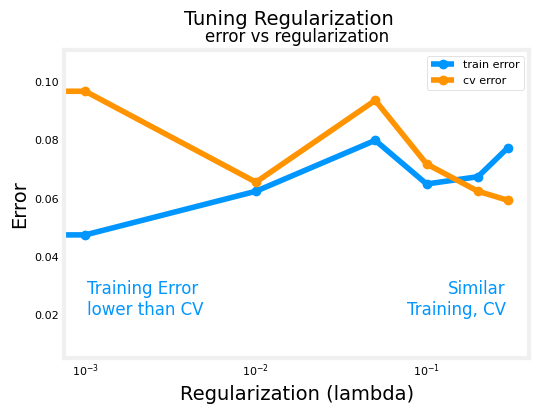

In [38]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 3ms/step


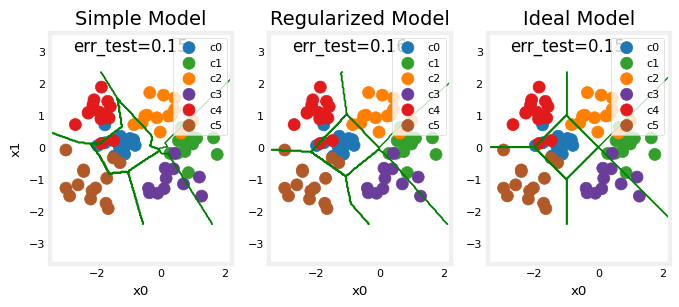

In [39]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)